<h1 align="center">S2R Analytics</h1>

# Table of Contents

* [1](#1): Projects
* [2](#2): Transactions
* [3](#3): Staff & teams
* [4](#4): Stages
* [5](#5): Clients 
* [6](#6): Clean-up
* [7](#7): Pre-processing

## Notebook Setup

In [68]:
# Essentials
import pandas as pd
from pandas import Series, DataFrame
from pandas.api.types import CategoricalDtype
pd.options.display.max_columns = None
import numpy as np; np.random.seed(2022)
import random
import sqlite3
import pyodbc
import copy

# Image creation and display
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import matplotlib.patches as mpatches
from matplotlib import pyplot
import plotly.express as px
import plotly.graph_objects as go

# Preprocessing
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_transformer
from statsmodels.stats.outliers_influence import variance_inflation_factor 

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn import svm
from sklearn.naive_bayes import GaussianNB
from sklearn.base import clone
from sklearn.ensemble import StackingClassifier
from sklearn.ensemble import BaggingClassifier

# Other
import itertools as it
import io
import os
os.sys.path
import sys
import glob
import concurrent.futures
from __future__ import print_function
import binascii
import struct
from PIL import Image
import scipy
import scipy.misc
import scipy.cluster
import datetime, time
import functools, operator
from datetime import datetime

## 1. <a class="anchor" id="1"></a> Projects

Step 1: Create a list of projects to drop.

In [2]:
# Read all projects from Synergy API
all_projects = pd.read_csv('csv-files/wga_synergy_incremental_projects.csv')
all_projects = all_projects[['Project ID', 'Project Number', 'Project Name', 'Is Office Project', 'Is Billable', 'Project Status']]

# Projects to keep: external (i.e. client only)
external_projects = all_projects[(all_projects['Is Office Project'] != 'Yes')]
external_projects = external_projects[(external_projects['Is Billable'] != 'No')]
external_ids = external_projects['Project ID'].tolist()

# Projects to keep: status-based
successful_projects = external_projects[external_projects['Project Status'].isin(['Complete']) == True]
valid_ids = successful_projects['Project ID'].tolist()

# See how many unique projects we shold have
print('We should have ' + str(len(valid_ids)) + ' projects in total.')

We should have 7222 projects in total.


In [3]:
print('Hence, ' + str(len(all_projects) - len(valid_ids)) + ' projects were dropped for being invalid.')

Hence, 8103 projects were dropped for being invalid.


Step 2: Cleaning data from Synergy API.

In [4]:
# Load only valid projects
api_projects = pd.read_csv('csv-files/wga_synergy_incremental_projects.csv', parse_dates=['Start Date (Project)', 'End Date (Project)'], dayfirst=True)
api_projects = (api_projects[api_projects['Project ID'].isin(valid_ids)])


# Drop unnecesary columns
api_projects.drop(columns = ['Unnamed: 0', 'Primary Contact Name', 'Status Name', 'Organisation ID',
                             'customFields', 'Address Line 1', 'Address Line 2', 'Project Type ID',
                             'Primary Contact', 'Primary Contact ID', 'Project Scope', 'Address Postal Code',
                             'Address State', 'Address Town', 'Address Google', 'Client Reference Number',
                             'Address State Postal Code Country', 'Address Single Line', 'Project Type Code',
                             'External Name', 'Address Longitude', 'Address Latitude', 'Project Manager', 
                             'Project Forecast Value', 'Created Date', 'Updated Date'], inplace = True)


# Convert columns for unified style
api_projects.rename(columns = {'Invoices':'Number of Invoices', 'Project Net Residual (Neg as Zero)':'Project Net Residual',
                              'Start Date (Project)': 'Project Start Date', 'End Date (Project)': 'Project End Date',
                              'Address Country':'Country', 'Project Type': 'Sector'}, inplace = True)
api_projects['Country'].replace(['AUSTRALIA', 'AUS', 'Autralia', 'NZ', 'new zealand', 'PNG', 'samoa', 'SAMOA', 'TONGA', 'SA', 'CHINA'],
                                ['Australia', 'Australia', 'Australia', 'New Zealand', 'New Zealand', 'Papua New Guinea', 'Samoa', 'Samoa', 'Tonga', 'Saudi Arabia', 'China'],inplace=True)


# Generalise minority observations into bigger groups
api_projects['Sector'].mask(api_projects['Sector'] == 'Commercial', 'Commercial & Retail Buildings', inplace=True)
api_projects['Sector'].mask(api_projects['Sector'] == 'Residential', 'Civic & Education Buildings', inplace=True)
api_projects['Default Rate Group'].mask(api_projects['Default Rate Group'] != 'Standard', 'Non-standard', inplace=True)


# Adding 'Due Date' and'Project Director' columns
custom_fields = pd.read_csv('csv-files/wga_synergy_incremental_projects_custom_fields.csv')
custom_fields = custom_fields[['PROPOSAL - Due Date', 'PROSPECT - Project Director', 'Project ID']].copy()
custom_fields.rename(columns = {'PROSPECT - Project Director':'Project Director', 'PROPOSAL - Due Date': 'Due Date'}, inplace = True)
custom_fields['Project Director'] = custom_fields['Project Director'].str.rstrip(' (MPD)')
custom_fields['Due Date'] = pd.to_datetime(custom_fields['Due Date'])
api_projects = pd.merge(api_projects, custom_fields,  how='left', on='Project ID')


# Rearrange column names for easier interpretation
api_projects = api_projects[['Project ID', 'Country',
                             'Project Status', 'Sector',
                             'Project Director', 'Manager ID', 'Office',
                             'Project Start Date', 'Project End Date', 'Due Date']]

len(api_projects)

7222

Step 3: Cleaning transformed PowerBI data from S2R Analytics.

In [5]:
# Read the pre-transformed data from PowerBI
pbi_projects = pd.read_csv('csv-files/wga_power_bi_projects.csv', encoding = 'ISO-8859-1', low_memory=False)
pbi_projects = pbi_projects[['Project ID', 'Project Size Sort Order', 'Is Multi Discipline Project','Is First Client Project']]

# Load only valid projects
pbi_projects = (pbi_projects[pbi_projects['Project ID'].isin(valid_ids)])

# Convert columns for unified style
pbi_projects['Is Multi Discipline Project'].replace(['No', 'Yes'],[False, True],inplace=True)
pbi_projects['Is First Client Project'].replace(['No', 'Yes'],[False, True],inplace=True)

# Convert the object column to boolean
pbi_projects['Is Multi Discipline Project'] = pbi_projects['Is Multi Discipline Project'].astype(bool)
pbi_projects['Is Multi Discipline Project'] = pbi_projects['Is Multi Discipline Project'].astype(int)
pbi_projects['Is First Client Project'] = pbi_projects['Is First Client Project'].astype(int)

len(pbi_projects)

7222

Step 4: Merge the two 'Projects' tables together.

In [6]:
# Merge the projects table from API and preprocesed Power BI table
projects = pd.merge(api_projects, pbi_projects,  how='left', left_on='Project ID', right_on='Project ID')
projects.columns = projects.columns.str.replace(' ', '_')
projects.head(1)

,Project_ID,Country,Project_Status,Sector,Project_Director,Manager_ID,Office,Project_Start_Date,Project_End_Date,Due_Date,Project_Size_Sort_Order,Is_Multi_Discipline_Project,Is_First_Client_Project
0,367704,Australia,Complete,Ports & Marine,Mark Gilbert,7612852,Whyalla,2015-07-01,2015-08-01,NaT,4,0,1


## 2. <a class="anchor" id="2"></a> Transactions

In [7]:
# Read only valid projects' transactions from Synergy API.
transactions = pd.read_csv('csv-files/wga_sql_transactions.csv', parse_dates=['date'], dayfirst=True, low_memory=False)
transactions = (transactions[transactions['projectId'].isin(valid_ids)])

transactions = transactions[['id', 'projectId', 'stageId', 'staffId', 'transactionTypeId',
                             'rateType', 'status','units',
                             'invoiceValueTotal','actualCostTotal', 'date']]

transactions.rename(columns = {'id':'Transaction ID', 'projectId':'Project ID',
                                'staffId':'Staff ID',
                               'transactionTypeId': 'Transaction Type',
                               'rateType': 'Rate Type', 'status': 'Status',
                               'stageId': 'Stage ID', 'date':'Date',
                               'invoiceValueTotal': 'Invoice Value Total',
                               'actualCostTotal':'Actual Cost Total',
                               'units': 'Units'}, inplace = True)

transactions = transactions[(transactions['Status'] == 'Invoiced') | (transactions['Status'] == 'Written off')]
transactions['Transaction Type'].replace([100, 200, 300, 400, 500, 700, 750, 800],
                                         ['Time', 'Cash', 'Travel', 'Office', 'Bill', 'Balance', 'Unearned', 'Invoice Custom'], inplace=True)
transactions['Date'] = pd.to_datetime(transactions['Date'])
transactions.columns = transactions.columns.str.replace(' ', '_')
transactions = transactions[['Project_ID', 'Staff_ID', 'Transaction_Type', 'Invoice_Value_Total', 'Actual_Cost_Total',  'Units', 'Rate_Type', 'Date']]

recorded_invoice = transactions.loc[transactions['Invoice_Value_Total'] != 0.0]
recorded_invoice_ids = recorded_invoice['Project_ID'].tolist()
transactions = (transactions[transactions['Project_ID'].isin(recorded_invoice_ids)])
transactions = transactions[(transactions['Transaction_Type'] == 'Time') | (transactions['Transaction_Type'] == 'Bill')]

print('Only ' + str(transactions['Project_ID'].nunique()) + ' projects have transaction recorded, meaning ' + str(len(projects) - transactions['Project_ID'].nunique()) + ' projects will be missing from transaction table.')
transactions.reset_index(inplace=True, drop=True)
transactions

Only 6337 projects have transaction recorded, meaning 885 projects will be missing from transaction table.


,Project_ID,Staff_ID,Transaction_Type,Invoice_Value_Total,Actual_Cost_Total,Units,Rate_Type,Date
0,768524,8553176.0,Time,0.00,203.975,2.5,Staff,2021-06-02
1,768524,8553176.0,Time,0.00,81.590,1.0,Staff,2021-06-03
2,768524,8553176.0,Time,0.00,40.795,0.5,Staff,2021-06-04
3,768524,7612693.0,Time,0.00,771.540,6.0,Staff,2021-06-02
4,768524,7612942.0,Time,0.00,284.625,2.5,Staff,2021-07-01
...,...,...,...,...,...,...,...,...
527953,1116173,7613114.0,Time,256.12,211.140,2.0,Staff,2022-03-16
527954,1116173,7613159.0,Time,351.25,306.360,4.0,Staff,2022-03-17
527955,1116173,7613159.0,Time,526.87,459.540,6.0,Staff,2022-03-18
527956,1116173,7613114.0,Time,64.03,52.785,0.5,Staff,2022-03-17


### 2.1 <a class="anchor" id="2.1"></a> Creating and investigating profit margins

In [8]:
# Profit_Margin
df_8 = pd.DataFrame(transactions.groupby(['Project_ID'])[['Invoice_Value_Total', 'Actual_Cost_Total']].sum()).reset_index()
df_8['Profit_Margin'] = (df_8['Invoice_Value_Total'] - df_8['Actual_Cost_Total'])/ df_8['Invoice_Value_Total']
print('Profit margins vary between ' + str(df_8['Profit_Margin'].min()) + ' and ' + str(df_8['Profit_Margin'].max()) + '.')

Profit margins vary between -inf and 1.0.


In [9]:
positives = df_8.loc[df_8['Profit_Margin'] > 0]
print('There are ' + str(len(positives)) + ' projects with profit margin higher than 0.')
negatives = df_8.loc[df_8['Profit_Margin'] < 0]
print('There are ' + str(len(negatives)) + ' projects with profit margin lower than 0.')
zeros = df_8.loc[df_8['Profit_Margin'] == 0]
print('There are ' + str(len(zeros)) + ' projects with profit margin equal to 0.')

There are 5443 projects with profit margin higher than 0.
There are 889 projects with profit margin lower than 0.
There are 5 projects with profit margin equal to 0.


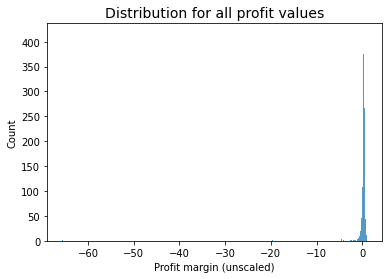

In [10]:
# No scaling with outliers
ax = plt.gca()
sns.histplot(df_8['Profit_Margin'], linewidth=0)
plt.xlabel('Profit margin (unscaled)')
plt.title('Distribution for all profit values', size=14)
plt.show()

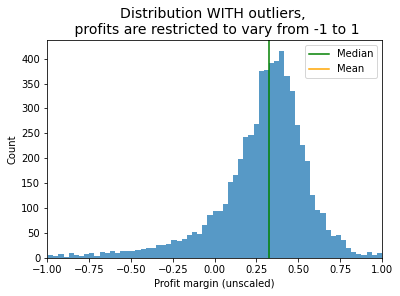

In [11]:
# No scaling, with outliers
ax = plt.gca()
ax.set_xlim([-1.0, 1.0])
sns.histplot(df_8['Profit_Margin'], linewidth=0)
plt.xlabel('Profit margin (unscaled)')

profit = df_8['Profit_Margin']
median=profit.median()
plt.axvline(median, color='green', linestyle='-', label='Median')
mean=profit.mean()
ax.axvline(mean, color='orange', linestyle='-', label='Mean')
ax.legend()
ax.grid(False)
plt.title('Distribution WITH outliers, \n profits are restricted to vary from -1 to 1', size=14)
plt.show()

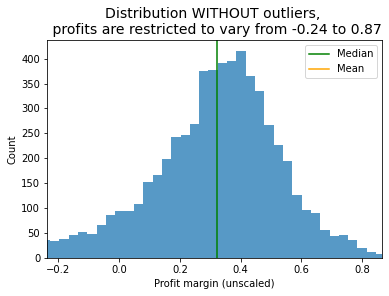

In [12]:
# No scaling, no outliers
ax = plt.gca()
ax.set_xlim([-0.23686749999999998, 0.8659844999999999])
sns.histplot(df_8['Profit_Margin'], linewidth=0)
plt.xlabel('Profit margin (unscaled)')

profit = df_8['Profit_Margin']
median=profit.median()
plt.axvline(median, color='green', linestyle='-', label='Median')
mean=profit.mean()
ax.axvline(mean, color='orange', linestyle='-', label='Mean')
ax.legend()
ax.grid(False)
plt.title('Distribution WITHOUT outliers, \n profits are restricted to vary from -0.24 to 0.87', size=14)
plt.show()

In [13]:
df_8['Profit_Margin'].quantile([0.25, 0.75], interpolation='nearest')

0.25    0.158614
0.75    0.448031
Name: Profit_Margin, dtype: float64

In [14]:
# Calculate the minimum and maximum bounds aside outliers
q1 = 0.158614
q3 = 0.448031
minimum = q1 - 1.5*(q3-q1)
maximum = q3 + 1.5*(q3-q1)

print('Minimum is ', str(minimum), '\nMaximum is ', str(maximum), '\nMedium is ', str(df_8['Profit_Margin'].median()))

Minimum is  -0.2755115 
Maximum is  0.8821565 
Medium is  0.32395440000000003


<AxesSubplot:>

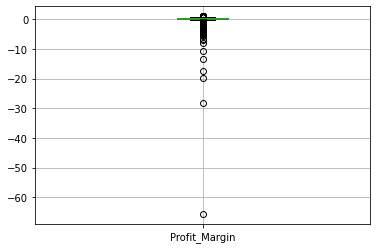

In [15]:
# Boxplot with outliers
df_8.boxplot('Profit_Margin', showfliers=True)

<AxesSubplot:>

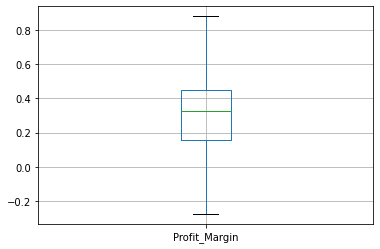

In [16]:
# Boxplot without outliers
df_8.boxplot('Profit_Margin', showfliers=False)

In [17]:
# Add the 'Profit_Margin' to the 'Projects' table
projects = pd.merge(df_8, projects, how='left', on='Project_ID')
projects.drop(['Invoice_Value_Total', 'Actual_Cost_Total'], axis=1, inplace = True)

### 2.2 <a class="anchor" id="2.2"></a> Creating other transaction-based features

Perc_of_Subcontractors = 
* total units of subcontractors divided by
* sum of units where transaction type is 'bill' or 'time'

* 'Time' = Company's employees
* 'Bill' = Hired subcontrators
* Time + Bill = total human capital on project in hours

In [18]:
# Perc_of_Subcontractors
subs = transactions[['Project_ID', 'Units', 'Rate_Type', 'Transaction_Type']]
subs = subs[(subs['Rate_Type'] == 'Subcontractor')]
subs.drop(columns = ['Rate_Type'], inplace = True)
subs = pd.DataFrame(subs.groupby(['Project_ID'])['Units'].sum()).reset_index()
subs.rename(columns = {'Units': 'Sub_Hours_Per_Project'}, inplace = True)

total_hours = transactions[['Project_ID', 'Units', 'Transaction_Type']]
total_hours = total_hours[(total_hours['Transaction_Type'] == 'Time') | (total_hours['Transaction_Type'] == 'Bill')]
total_hours = pd.DataFrame(total_hours.groupby(['Project_ID'])['Units'].sum()).reset_index()
total_hours.rename(columns = {'Units': 'Total_Hours_Per_Project'}, inplace = True)

df_1 = pd.merge(projects, subs, how='left', on='Project_ID')
df_1['Sub_Hours_Per_Project'].fillna(0, inplace=True)
df_2 = pd.merge(df_1, total_hours, how='left', on='Project_ID')
df_2['Total_Hours_Per_Project'].fillna(0, inplace=True)
df_2['Sub_Hours_Per_Project'].isnull().sum(), df_2['Total_Hours_Per_Project'].isnull().sum()
df_2['Perc_of_Subcontractors'] = (df_2['Sub_Hours_Per_Project']/df_2['Total_Hours_Per_Project']).round(decimals = 2)*100
df_2 = df_2[['Project_ID', 'Perc_of_Subcontractors']]

# Add the new feature to the 'Projects' table
projects = pd.merge(projects, df_2,  how='left', left_on='Project_ID', right_on='Project_ID')
len(projects)

6337

In [19]:
# Is_Front_Loaded
project_dates = projects[['Project_ID', 'Project_Start_Date', 'Project_End_Date']]
df_3 = transactions[['Project_ID', 'Units', 'Date']]
df_3 = pd.merge(df_3, project_dates, how='left', left_on='Project_ID', right_on='Project_ID')

first_half = df_3[(df_3['Date']  < df_3['Project_Start_Date'] + (df_3['Project_End_Date'] - df_3['Project_Start_Date'])/2)] # finding mid-point between 2 dates
first_half = pd.DataFrame(first_half.groupby(['Project_ID'])['Units'].sum()).reset_index()
first_half.rename(columns = {'Units': '1st_Half_Units'}, inplace = True)

total_units = pd.DataFrame(df_3.groupby(['Project_ID'])['Units'].sum()).reset_index()
total_units.rename(columns = {'Units': 'Total_Effort_Units'}, inplace = True)

df_4 = pd.merge(total_units, first_half, how ='left', left_on='Project_ID', right_on='Project_ID')
df_4['Perc_Being_Front'] = df_4['1st_Half_Units']/df_4['Total_Effort_Units']
df_4['Is_Front_Loaded'] = (df_4['Perc_Being_Front']>=0.7)
df_4 = df_4[['Project_ID', 'Is_Front_Loaded']]

# Add the new feature to the 'Projects' table
projects = pd.merge(projects, df_4,  how='left', left_on='Project_ID', right_on='Project_ID')
len(projects)

6337

In [20]:
# Project_Start_Date, Project_End_Date

def nat_check(date):
    if type(date) == pd._libs.tslibs.nattype.NaTType:
        return True
    else:
        return False

min_dates =  pd.DataFrame(transactions.groupby(['Project_ID'])['Date'].min()).reset_index()
min_dates.rename(columns = {'Date':'Min_Date'}, inplace = True)
max_dates =  pd.DataFrame(transactions.groupby(['Project_ID'])['Date'].max()).reset_index()
max_dates.rename(columns = {'Date':'Max_Date'}, inplace = True)
all_dates = pd.merge(min_dates, max_dates, how='left', on='Project_ID')
projects = pd.merge(projects, all_dates, how='left', on='Project_ID')
len(projects)

6337

In [21]:
projects['Project_Start_Date'] = projects['Project_Start_Date'].map(str)
projects['Project_End_Date'] = projects['Project_End_Date'].map(str)
projects['Due_Date'] = projects['Due_Date'].map(str)

projects.loc[projects['Project_Start_Date']=='NaT','Project_Start_Date']=projects['Min_Date']
projects.loc[projects['Project_End_Date']=='NaT','Project_End_Date']=projects['Max_Date']
projects.loc[projects['Due_Date']=='NaT','Due_Date']=projects['Max_Date']

projects['Project_Start_Date'] = pd.to_datetime(projects['Project_Start_Date'])
projects['Project_End_Date'] = pd.to_datetime(projects['Project_End_Date'])
projects['Due_Date'] = pd.to_datetime(projects['Due_Date'])

projects.drop(columns = ['Min_Date', 'Max_Date'], inplace = True)
len(projects)

6337

Now, let's go back to engieering date-dependent features with newly filled in values in the 'Projects' table.

In [22]:
# Project_Duration_Weeks
projects['Project_Duration_Weeks'] = (projects['Project_End_Date'] - projects['Project_Start_Date']).astype('timedelta64[W]')
neg_weeks = projects[(projects['Project_Duration_Weeks'] < 0)]
neg_ids = neg_weeks['Project_ID'].tolist()
neg_weeks = (projects[projects['Project_ID'].isin(neg_ids)])
neg_weeks

,Project_ID,Profit_Margin,Country,Project_Status,Sector,Project_Director,Manager_ID,Office,Project_Start_Date,Project_End_Date,Due_Date,Project_Size_Sort_Order,Is_Multi_Discipline_Project,Is_First_Client_Project,Perc_of_Subcontractors,Is_Front_Loaded,Project_Duration_Weeks
4592,376189,0.557152,Australia,Complete,Health & Aged Care,Cameron Jackson,7612841,WGAVIC Pty Ltd,2019-09-23,1970-01-01,2019-09-24,1,0,0,0.0,False,-2595.0


In [23]:
# Manually substitute those dates that don't make sense from transactions to created and updates dates from the opriginal API table.
projects.loc[projects['Project_ID'] == 376189, 'Project_Start_Date'] = pd.to_datetime('13/08/2019')
projects.loc[projects['Project_ID'] == 376189, 'Project_End_Date'] = pd.to_datetime('25/02/2020')

projects.loc[projects['Project_ID'] == 1311624, 'Project_Start_Date'] = pd.to_datetime('07/12/2021')
projects.loc[projects['Project_ID'] == 1311624, 'Project_End_Date'] = pd.to_datetime('24/01/2022')

In [24]:
projects['Project_Duration_Weeks'] = (projects['Project_End_Date'] - projects['Project_Start_Date']).astype('timedelta64[W]')
neg_weeks = projects[(projects['Project_Duration_Weeks'] < 0)]
neg_ids = neg_weeks['Project_ID'].tolist()
neg_weeks = (projects[projects['Project_ID'].isin(neg_ids)])
neg_weeks

,Project_ID,Profit_Margin,Country,Project_Status,Sector,Project_Director,Manager_ID,Office,Project_Start_Date,Project_End_Date,Due_Date,Project_Size_Sort_Order,Is_Multi_Discipline_Project,Is_First_Client_Project,Perc_of_Subcontractors,Is_Front_Loaded,Project_Duration_Weeks


In [25]:
# Delivered_on_Time
    
Delivered_on_Time = {}

for due_date in projects['Due_Date']:
    for completed in projects['Project_End_Date']:
        if nat_check(due_date) == True:
            continue
        else:
            if due_date <= completed:
                Delivered_on_Time[due_date] = True
            else:
                Delivered_on_Time[due_date] = False

df_7 = pd.DataFrame([{'Due_Date': due_date, 'Delivered_on_Time': is_on_time} for (due_date, is_on_time) in Delivered_on_Time.items()])

projects = pd.merge(projects, df_7, how='left', on='Due_Date')

## 3. <a class="anchor" id="3"></a> Staff & teams

This section resulted in *aec.staff* table in RDS for Client X.

In [26]:
active = pd.read_csv('csv-files/wga_synergy_overnight_1_staff.csv', parse_dates=['Employment Date'], dayfirst=True)
active = active[['Staff ID', 'Staff Name', 'Employment Date', 'Synergy Team']]
active['Employment Date'] = pd.to_datetime(active['Employment Date'])
active['Employment Months'] = ((datetime.now() - active['Employment Date']).astype('timedelta64[M]'))
active.columns = active.columns.str.replace(' ', '_')

leavers = pd.read_csv('csv-files/wga_synergy_overnight_1_staff_-_leavers.csv', parse_dates=['Employment Date', 'Termination Date'], dayfirst=True)
leavers = leavers[['Staff ID', 'Staff Name', 'Employment Date', 'Termination Date', 'Synergy Team']]
leavers['Employment Date'] = pd.to_datetime(leavers['Employment Date'])
leavers['Termination Date'] = pd.to_datetime(leavers['Termination Date'])
leavers['Employment Months'] = ((leavers['Termination Date'] - leavers['Employment Date']).astype('timedelta64[M]'))
leavers.columns = leavers.columns.str.replace(' ', '_')

staff = pd.concat([active, leavers], axis = 0, ignore_index = True) # axis=0 specifies vertical stacking
staff = staff[['Staff_ID', 'Staff_Name', 'Synergy_Team', 'Employment_Months', 'Employment_Date', 'Termination_Date']]
staff

,Staff_ID,Staff_Name,Synergy_Team,Employment_Months,Employment_Date,Termination_Date
0,7612683,Mel Chittleborough,SA - Finance,264.0,2000-09-25,NaT
1,7612686,Andrew Woods,SA - Buildings,437.0,1986-04-25,NaT
2,7612687,Adam Fairhead,SA - Buildings,200.0,2006-01-08,NaT
3,7612688,Alex Granegger Carneiro,SA - Buildings,252.0,2001-09-17,NaT
4,7612691,Alex Lloyd,SA - Civil,178.0,2007-11-12,NaT
...,...,...,...,...,...,...
820,10019349,Tori Davidson,SA - Industrial,1.0,2022-02-01,2022-03-18
821,10053476,Delete Delete,WA - Structural,0.0,2022-01-01,2022-01-01
822,10069064,Rianna Radocchia,WA - Project Delivery Services,1.0,2022-03-14,2022-05-06
823,10077594,Michael Salib,WA - Project Delivery Services,0.0,2022-04-26,2022-04-26


**8 features to engineer and move them all to 'Projects' table:**
* Director_Empl_Months 
* Manager_Empl_Months
* Manager_Is_Recent
* Director_Is_Recent
<br>
<br>
* Team_Size
* Perc_Team_Recent
* Is_Multi_Team
* Num_Teams_Involved

In [27]:
# Director_Is_Recent, Director_Empl_Months

directors = projects[['Project_ID', 'Project_Director', 'Project_Start_Date']]
directors = pd.merge(directors, staff, how='left', left_on='Project_Director', right_on='Staff_Name')
directors.rename(columns = {'Synergy_Team':'Director_Team', 'Employment_Months':'Director_Empl_Months'}, inplace = True)
directors['Months_Before_Project'] = (directors['Project_Start_Date'] - directors['Employment_Date']).astype('timedelta64[M]')
directors.drop(columns = ['Staff_Name', 'Project_Start_Date'], inplace = True)

Director_Is_Recent = {}

for months in directors['Months_Before_Project']:
    if np.isnan(months) == True:
        continue
    else:
        if months < 6:
            Director_Is_Recent[months] = True
        else:
            Director_Is_Recent[months] = False
        
df_13 = pd.DataFrame([{'Months_Before_Project': months, 'Director_Is_Recent': recent_status} for (months, recent_status) in Director_Is_Recent.items()])

directors = pd.merge(directors, df_13, how ='left', on='Months_Before_Project')
directors.drop(columns = ['Employment_Date', 'Termination_Date', 'Months_Before_Project'], inplace = True)
projects = pd.merge(projects, directors, how ='left', on=['Project_ID', 'Project_Director'])
projects.rename(columns = {'Staff_ID':'Director_ID'}, inplace = True)
projects.drop(columns = 'Project_Director', inplace = True)
len(projects)

6337

In [28]:
# Manager_Is_Recent, Manager_Empl_Months

managers = projects[['Project_ID', 'Manager_ID', 'Project_Start_Date']]
managers = pd.merge(managers, staff, how='left', left_on='Manager_ID', right_on='Staff_ID')
managers.rename(columns = {'Synergy_Team':'Manager_Team', 'Employment_Months':'Manager_Empl_Months'}, inplace = True)
managers['Months_Before_Project'] = (managers['Project_Start_Date'] - managers['Employment_Date']).astype('timedelta64[M]')
managers.drop(columns = ['Staff_ID', 'Staff_Name', 'Project_Start_Date'], inplace = True)  

Manager_Is_Recent = {}

for months in managers['Months_Before_Project']:
    if np.isnan(months) == True:
        continue
    else:
        if months < 6:
            Manager_Is_Recent[months] = True
        else:
            Manager_Is_Recent[months] = False
        
df_14 = pd.DataFrame([{'Months_Before_Project': months, 'Manager_Is_Recent': recent_status} for (months, recent_status) in Manager_Is_Recent.items()])

managers = pd.merge(managers, df_14, how ='left', on='Months_Before_Project')
managers = managers[['Project_ID', 'Manager_ID', 'Manager_Team', 'Manager_Empl_Months', 'Manager_Is_Recent']]

projects = pd.merge(projects, managers, how ='left', on=['Project_ID', 'Manager_ID'])
len(projects)

6337

In [29]:
type(staff['Staff_ID'][0])

numpy.int64

In [30]:
type(transactions['Staff_ID'][0])

numpy.float64

In [31]:
nulls = pd.DataFrame(transactions['Staff_ID'].isnull())
nulls.rename(columns = {'Staff_ID':'checker'}, inplace = True)
nulls = nulls.loc[nulls['checker'] == True]
unrecorded_staff_ids = list(nulls.index.values)
nulls = transactions.iloc[unrecorded_staff_ids]
nulls

,Project_ID,Staff_ID,Transaction_Type,Invoice_Value_Total,Actual_Cost_Total,Units,Rate_Type,Date
143,827515,NaN,Bill,0.0,4120.0000,1.0000,Supplier,2021-08-26
255,1074576,NaN,Bill,3125.0,3125.0000,1.0000,Supplier,2021-08-24
393,623346,NaN,Bill,0.0,40.5698,0.5659,Supplier,2021-07-01
406,566366,NaN,Bill,523.0,523.0000,1.0000,Supplier,2021-08-27
407,372227,NaN,Bill,0.0,49.9000,1.0000,Supplier,2021-08-26
...,...,...,...,...,...,...,...,...
527725,756305,NaN,Bill,2730.0,2730.0000,1.0000,Supplier,2022-02-28
527727,756305,NaN,Bill,25.0,25.0000,1.0000,Supplier,2022-01-13
527728,756305,NaN,Bill,25.0,25.0000,1.0000,Supplier,2022-01-13
527814,383337,NaN,Bill,0.0,35.1363,1.0000,Supplier,2022-01-01


In [32]:
len(transactions) - len(unrecorded_staff_ids)

516527

In [33]:
transactions = transactions.drop(index=unrecorded_staff_ids)
len(transactions)

516527

In [34]:
transactions['Staff_ID'] = (transactions['Staff_ID'].astype('int64'))
teams = pd.merge(transactions, staff, how='left', on='Staff_ID')
len(projects) - teams['Project_ID'].nunique()

8

In [35]:
# Num_Teams_Involved
df_16 = pd.DataFrame(teams.groupby(['Project_ID'])['Synergy_Team'].nunique()).reset_index()
df_16.rename(columns = {'Synergy_Team':'Num_Teams_Involved'}, inplace = True)

# Is_Multi_Team
df_16['Is_Multi_Team'] = (df_16['Num_Teams_Involved'] > 1)
df_16['Is_Multi_Team'].value_counts()

# Add 'Num_Teams_Involved' and 'Is_Multi_Team' to the 'Projects' table. Missing values will be accounted for in part 8 (pre-processing).
projects = pd.merge(projects, df_16, how='left', on='Project_ID')

In [36]:
# Team_Size
df_17 = pd.DataFrame(teams.groupby(['Project_ID'])['Staff_ID'].nunique()).reset_index()
df_17.rename(columns = {'Staff_ID':'Team_Size'}, inplace = True)
projects = pd.merge(projects, df_17, how='left', on='Project_ID')

In [37]:
# Perc_of_Team_Recent
pr_start_dates = pd.DataFrame(projects[['Project_ID', 'Project_Start_Date']])
recency = pd.DataFrame(teams[['Project_ID', 'Staff_ID', 'Employment_Date']])
recency.drop_duplicates(inplace = True, ignore_index=True)
df_19 = pd.merge(recency, pr_start_dates, how='left', on='Project_ID')
df_19['Months_Before_Project'] = (df_19['Project_Start_Date'] - df_19['Employment_Date']).astype('timedelta64[M]')
df_19 = df_19[['Project_ID', 'Staff_ID', 'Months_Before_Project']]
teams = pd.merge(teams, df_19, how ='left', on=['Project_ID', 'Staff_ID'])

Staff_Is_Recent = {}

for months in df_19['Months_Before_Project']:
    if np.isnan(months) == True:
        continue
    else:
        if months < 6:
            Staff_Is_Recent[months] = True
        else:
            Staff_Is_Recent[months] = False
        
df_20 = pd.DataFrame([{'Months_Before_Project': months, 'Staff_Is_Recent': recency_status} for (months, recency_status) in Staff_Is_Recent.items()])

df_21 = pd.merge(teams, df_20, how='left', on='Months_Before_Project')
df_21 = df_21[['Project_ID', 'Staff_ID', 'Staff_Is_Recent']]
df_21.drop_duplicates(inplace = True, ignore_index=True)
df_22 = pd.DataFrame(df_21.groupby(['Project_ID'])['Staff_Is_Recent'].sum()).reset_index()
df_22.rename(columns = {'Staff_Is_Recent':'Num_of_Recent_Staff'}, inplace = True)
df_22 = pd.merge(df_17, df_22, how='left', on='Project_ID')
df_22['Perc_of_Team_Recent'] = ((df_22['Num_of_Recent_Staff'] / df_22['Team_Size'])*100).round(decimals = 2)
df_22 = df_22[['Project_ID', 'Perc_of_Team_Recent']]
projects = pd.merge(projects, df_22, how='left', on='Project_ID')
projects.head(1)

,Project_ID,Profit_Margin,Country,Project_Status,Sector,Manager_ID,Office,Project_Start_Date,Project_End_Date,Due_Date,Project_Size_Sort_Order,Is_Multi_Discipline_Project,Is_First_Client_Project,Perc_of_Subcontractors,Is_Front_Loaded,Project_Duration_Weeks,Delivered_on_Time,Director_ID,Director_Team,Director_Empl_Months,Director_Is_Recent,Manager_Team,Manager_Empl_Months,Manager_Is_Recent,Num_Teams_Involved,Is_Multi_Team,Team_Size,Perc_of_Team_Recent
0,367704,0.076153,Australia,Complete,Ports & Marine,7612852,Whyalla,2015-07-01,2015-08-01,2018-12-13,4,0,1,0.0,True,4.0,True,7612709.0,SA - Industrial,434.0,False,SA - Industrial,128.0,False,5.0,True,12.0,8.33


## 4. <a class="anchor" id="4"></a> Stages

This section resulted in *aec.stages* table in RDS for Client X.

In [38]:
# Read only valid projects' stages
stages = pd.read_csv('csv-files/wga_power_bi_stages.csv', encoding = 'ISO-8859-1', low_memory=False)
stages = (stages[stages['Project ID'].isin(valid_ids)])
stages = stages[(stages['Stage Type'] != 'Proposal')] # We only want professional fees
stages = stages[['Project ID', 'Stage ID', 'Stage Fee Type', 'Is Disbursement Stage',
                 'Stage Manager', 'Stage Discipline','Stage Start Date','Stage End Date']]

stages['Is Disbursement Stage'].replace(['No', 'Yes'], [False, True],inplace=True)
stages['Stage Start Date'] = pd.to_datetime(stages['Stage Start Date'])
stages['Stage End Date'] = pd.to_datetime(stages['Stage End Date'])
stages.columns = stages.columns.str.replace(' ', '_')
stages.drop(columns = 'Is_Disbursement_Stage', axis=1, inplace = True)
stages.head(1)

,Project_ID,Stage_ID,Stage_Fee_Type,Stage_Manager,Stage_Discipline,Stage_Start_Date,Stage_End_Date
0,368035,1390483,Hourly rates,Rick Penfold,Design,NaT,NaT


In [39]:
stages['Project_ID'].nunique()

7220

**1 feature to engineer:**
* Perc_of_Stages_with_Hourly_Rates

In [40]:
# Perc_of_Stages_with_Hourly_Rates
df_9 = pd.DataFrame(stages.groupby(['Project_ID', 'Stage_Fee_Type'])['Stage_ID'].count()).reset_index()
df_10 = pd.DataFrame(stages.groupby(['Project_ID'])['Stage_Fee_Type'].count()).reset_index()
df_10.rename(columns = {'Stage_Fee_Type':'Total_Num_Stages'}, inplace = True)
df_10 = pd.merge(df_9, df_10, how='left', on='Project_ID')
df_10.rename(columns = {'Stage_ID':'Num_of_Stages_Per_Type'}, inplace = True)
df_11 = df_10[(df_10['Stage_Fee_Type'] == 'Hourly rates')]
df_11['Perc_of_Stages_with_Hourly_Rates'] = ((df_11['Num_of_Stages_Per_Type'] / df_11['Total_Num_Stages'])*100).round(decimals = 2)
df_11 = df_11[['Project_ID', 'Perc_of_Stages_with_Hourly_Rates']]
df_12 = pd.merge(stages, df_11, how='left', on='Project_ID')
df_12['Perc_of_Stages_with_Hourly_Rates'] = df_12['Perc_of_Stages_with_Hourly_Rates'].fillna(0)
df_12 = df_12[['Project_ID', 'Perc_of_Stages_with_Hourly_Rates']].copy()
df_12.drop_duplicates(inplace = True, ignore_index=True)
projects = pd.merge(projects, df_12,  how ='left', on ='Project_ID')
projects

C:\Users\MarfaPopova\AppData\Local\Temp\ipykernel_20236\1982791734.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_11['Perc_of_Stages_with_Hourly_Rates'] = ((df_11['Num_of_Stages_Per_Type'] / df_11['Total_Num_Stages'])*100).round(decimals = 2)


,Project_ID,Profit_Margin,Country,Project_Status,Sector,Manager_ID,Office,Project_Start_Date,Project_End_Date,Due_Date,Project_Size_Sort_Order,Is_Multi_Discipline_Project,Is_First_Client_Project,Perc_of_Subcontractors,Is_Front_Loaded,Project_Duration_Weeks,Delivered_on_Time,Director_ID,Director_Team,Director_Empl_Months,Director_Is_Recent,Manager_Team,Manager_Empl_Months,Manager_Is_Recent,Num_Teams_Involved,Is_Multi_Team,Team_Size,Perc_of_Team_Recent,Perc_of_Stages_with_Hourly_Rates
0,367704,0.076153,Australia,Complete,Ports & Marine,7612852,Whyalla,2015-07-01,2015-08-01,2018-12-13,4,0,1,0.0,True,4.0,True,7612709.0,SA - Industrial,434.0,False,SA - Industrial,128.0,False,5.0,True,12.0,8.33,20.00
1,367705,0.626269,Australia,Complete,Civic & Education Buildings,7612773,WGASA Pty Ltd,2010-05-31,2018-04-23,2018-04-23,1,0,1,0.0,False,412.0,True,7612747.0,SA - Buildings,434.0,False,SA - Buildings,320.0,False,1.0,False,1.0,0.00,100.00
2,367706,0.483591,Australia,Complete,Civic & Education Buildings,7612773,WGASA Pty Ltd,2017-02-06,2017-02-07,2017-02-07,1,0,1,0.0,False,0.0,True,7612768.0,SA - Buildings,340.0,False,SA - Buildings,320.0,False,1.0,False,1.0,0.00,100.00
3,367707,0.005829,Australia,Complete,Commercial & Retail Buildings,7612773,WGASA Pty Ltd,2009-12-31,2017-04-21,2017-04-21,3,0,1,0.0,False,381.0,True,7612709.0,SA - Industrial,434.0,False,SA - Buildings,320.0,False,1.0,False,1.0,0.00,75.00
4,367708,-0.123592,Australia,Complete,Civic & Education Buildings,7612695,WGASA Pty Ltd,2009-12-31,2017-09-07,2017-09-07,7,0,1,0.0,False,401.0,True,7612695.0,SA - Buildings,422.0,False,SA - Buildings,422.0,False,1.0,False,1.0,0.00,100.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6332,1420741,0.379593,Australia,Complete,Resources,7612939,WGASA Pty Ltd,2022-02-22,2022-03-07,2022-02-24,2,0,0,0.0,False,1.0,True,8631459.0,QLD - QLD,23.0,False,SA - Industrial,84.0,False,1.0,False,4.0,0.00,100.00
6333,1420788,0.291487,Australia,Complete,Health & Aged Care,9683807,WGAVIC Pty Ltd,2022-02-23,2022-02-23,2022-02-25,1,0,0,0.0,False,0.0,True,7612775.0,SA - Buildings,228.0,False,VIC - Industrial,12.0,True,1.0,False,2.0,100.00,0.00
6334,1421714,0.498453,Australia,Complete,Ports & Marine,7613114,WGASA Pty Ltd,2022-02-24,2022-02-24,2022-04-07,1,0,0,0.0,False,0.0,False,7612852.0,SA - Industrial,128.0,False,SA - Industrial,49.0,False,1.0,False,2.0,0.00,33.33
6335,1458083,0.321337,Australia,Complete,Health & Aged Care,7612775,WGASA Pty Ltd,2022-03-21,2022-03-21,2022-04-04,1,0,0,0.0,False,0.0,False,7612775.0,SA - Buildings,228.0,False,SA - Buildings,228.0,False,2.0,True,3.0,0.00,33.33


In [41]:
# Stage_Duration_Weeks
df_4 = pd.DataFrame(stages['Stage_Start_Date'].notnull() & stages['Stage_End_Date'].notnull())
df_4.rename(columns = {0:'checker'}, inplace = True)
df_4 = df_4.loc[df_4['checker'] == True]

stages = pd.merge(stages, df_4, left_index=True, right_index=True)
stages['Stage_Duration_Weeks'] = ((stages['Stage_End_Date'] - stages['Stage_Start_Date']).astype('timedelta64[W]'))
stages.drop(columns = 'checker', inplace = True)

## 5. <a class="anchor" id="5"></a> Clients

This section resulted in *aec.clients* table in RDS for Client X.

Step 1: Cleaning all given data, from Synergy API and Power BI.

In [42]:
# Step 1: Cleaning data from Synergy API.
api_clients = pd.read_csv('csv-files/wga_synergy_overnight_1_clients.csv')
api_clients.drop(columns = {'Client Name', 'Unnamed: 0', 'Contact Type', 'Organisation ID'}, inplace = True)
api_clients['Created Date'] = pd.to_datetime(api_clients['Created Date'])

# Step 2: Cleaning transformed PowerBI data from S2R Analytics.
pbi_clients = pd.read_csv('csv-files/wga_power_bi_clients.csv', encoding = 'ISO-8859-1')
pbi_clients = pbi_clients[['Client ID', 'Client Projects - Total No', 'Client Projects - First Project ID']]
pbi_clients.rename(columns = {'Client Projects - Total No': 'Client Projects Total No',
                              'Client Projects - First Project ID':'1st Project ID'}, inplace = True)

# Step 3: Merge the two 'Clients' tables together.
clients = pd.merge(api_clients, pbi_clients,  how='left', left_on='Client ID', right_on='Client ID')
clients.columns = clients.columns.str.replace(' ', '_')
clients.head(1)

,Client_ID,Created_Date,Client_Projects_Total_No,1st_Project_ID
0,10317738,2022-05-06,NaN,NaN


In [43]:
clients['Client_ID'].nunique()

12306

**3 features to engineer:**
* Client_Duration_Months
* Client_Is_Repeated
* Client_Is_Recent

In [44]:
# Client_Is_Repeated
clients['Client_Is_Repeated'] = clients['1st_Project_ID'].notnull()

# Client_Duration_Months
clients['Client_Duration_Months'] = datetime.now() - clients['Created_Date']
clients['Client_Duration_Months'] = (clients['Client_Duration_Months'].astype('timedelta64[M]'))
clients['Client_Duration_Months'].isnull().sum()

0

In [45]:
# Client_Is_Recent

Client_Is_Recent = {}

for months in clients['Client_Duration_Months']:
    if months < 6:
        Client_Is_Recent[months] = True
    else:
        Client_Is_Recent[months] = False
         
df_12 = pd.DataFrame(
    [{'Client_Duration_Months': months, 'Client_Is_Recent': recent_status} for (months, recent_status) in Client_Is_Recent.items()])

clients = pd.merge(clients, df_12, how='left', on='Client_Duration_Months')
clients.head(1)

,Client_ID,Created_Date,Client_Projects_Total_No,1st_Project_ID,Client_Is_Repeated,Client_Duration_Months,Client_Is_Recent
0,10317738,2022-05-06,NaN,NaN,False,4.0,True


## 6. <a class="anchor" id="6"></a> Clean-up

In [46]:
projects.columns

Index(['Project_ID', 'Profit_Margin', 'Country', 'Project_Status', 'Sector',
       'Manager_ID', 'Office', 'Project_Start_Date', 'Project_End_Date',
       'Due_Date', 'Project_Size_Sort_Order', 'Is_Multi_Discipline_Project',
       'Is_First_Client_Project', 'Perc_of_Subcontractors', 'Is_Front_Loaded',
       'Project_Duration_Weeks', 'Delivered_on_Time', 'Director_ID',
       'Director_Team', 'Director_Empl_Months', 'Director_Is_Recent',
       'Manager_Team', 'Manager_Empl_Months', 'Manager_Is_Recent',
       'Num_Teams_Involved', 'Is_Multi_Team', 'Team_Size',
       'Perc_of_Team_Recent', 'Perc_of_Stages_with_Hourly_Rates'],
      dtype='object')

In [47]:
len(projects.columns)

29

In [48]:
# Drop columns unnecessary for analysis and rearrange
projects = projects[['Project_ID', 'Country', 'Office', 'Sector',
       'Project_Size_Sort_Order', 'Is_Multi_Discipline_Project',
       'Is_Multi_Team', 'Num_Teams_Involved', 'Team_Size', 'Perc_of_Team_Recent',
       'Is_First_Client_Project', 'Perc_of_Subcontractors', 'Is_Front_Loaded',
       'Project_Duration_Weeks', 'Delivered_on_Time',
       'Director_Is_Recent', 'Manager_Is_Recent',
        'Perc_of_Stages_with_Hourly_Rates', 'Profit_Margin']]

len(projects.columns)

19

Dropped 10 columns: Project Status, Manager ID, Director ID, Manager Team, Director Team, Project Start Date, Project End Date, Due Date, Director Employment Months, Manager Employment Months.

In [49]:
projects

,Project_ID,Country,Office,Sector,Project_Size_Sort_Order,Is_Multi_Discipline_Project,Is_Multi_Team,Num_Teams_Involved,Team_Size,Perc_of_Team_Recent,Is_First_Client_Project,Perc_of_Subcontractors,Is_Front_Loaded,Project_Duration_Weeks,Delivered_on_Time,Director_Is_Recent,Manager_Is_Recent,Perc_of_Stages_with_Hourly_Rates,Profit_Margin
0,367704,Australia,Whyalla,Ports & Marine,4,0,True,5.0,12.0,8.33,1,0.0,True,4.0,True,False,False,20.00,0.076153
1,367705,Australia,WGASA Pty Ltd,Civic & Education Buildings,1,0,False,1.0,1.0,0.00,1,0.0,False,412.0,True,False,False,100.00,0.626269
2,367706,Australia,WGASA Pty Ltd,Civic & Education Buildings,1,0,False,1.0,1.0,0.00,1,0.0,False,0.0,True,False,False,100.00,0.483591
3,367707,Australia,WGASA Pty Ltd,Commercial & Retail Buildings,3,0,False,1.0,1.0,0.00,1,0.0,False,381.0,True,False,False,75.00,0.005829
4,367708,Australia,WGASA Pty Ltd,Civic & Education Buildings,7,0,False,1.0,1.0,0.00,1,0.0,False,401.0,True,False,False,100.00,-0.123592
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6332,1420741,Australia,WGASA Pty Ltd,Resources,2,0,False,1.0,4.0,0.00,0,0.0,False,1.0,True,False,False,100.00,0.379593
6333,1420788,Australia,WGAVIC Pty Ltd,Health & Aged Care,1,0,False,1.0,2.0,100.00,0,0.0,False,0.0,True,False,True,0.00,0.291487
6334,1421714,Australia,WGASA Pty Ltd,Ports & Marine,1,0,False,1.0,2.0,0.00,0,0.0,False,0.0,False,False,False,33.33,0.498453
6335,1458083,Australia,WGASA Pty Ltd,Health & Aged Care,1,0,True,2.0,3.0,0.00,0,0.0,False,0.0,False,False,False,33.33,0.321337


## 7. <a class="anchor" id="7"></a> Pre-processing

### 7.1 <a class="anchor" id="7_1"></a> Missing values

In [50]:
df = copy.deepcopy(projects)
cols = df.columns[df.isnull().any()].to_list()

for c in cols:
    print(c, df[c].isnull().sum())

Country 55
Is_Multi_Team 8
Num_Teams_Involved 8
Team_Size 8
Perc_of_Team_Recent 8
Director_Is_Recent 1


First, let's deal with small amount of nulls.

In [51]:
df['Country'].fillna(df['Country'].value_counts().idxmax(), inplace = True)
df['Director_Is_Recent'].fillna(df['Director_Is_Recent'].value_counts().idxmax(), inplace = True)

In [52]:
df = copy.deepcopy(df)
cols = df.columns[df.isnull().any()].to_list()

for c in cols:
    print(c, df[c].isnull().sum())

Is_Multi_Team 8
Num_Teams_Involved 8
Team_Size 8
Perc_of_Team_Recent 8


In [53]:
nulls = pd.DataFrame(df['Is_Multi_Team'].isnull())
nulls.rename(columns = {'Is_Multi_Team':'checker'}, inplace = True)
nulls = nulls.loc[nulls['checker'] == True]
unrecorded_teams = list(nulls.index.values)
nulls = df.iloc[unrecorded_teams]
nulls

,Project_ID,Country,Office,Sector,Project_Size_Sort_Order,Is_Multi_Discipline_Project,Is_Multi_Team,Num_Teams_Involved,Team_Size,Perc_of_Team_Recent,Is_First_Client_Project,Perc_of_Subcontractors,Is_Front_Loaded,Project_Duration_Weeks,Delivered_on_Time,Director_Is_Recent,Manager_Is_Recent,Perc_of_Stages_with_Hourly_Rates,Profit_Margin
58,367834,Australia,WGASA Pty Ltd,Traffic Transport (Bridges),1,0,NaN,NaN,NaN,NaN,1,0.0,False,0.0,True,False,False,100.0,-1.156716e+00
67,367884,Australia,WGASA Pty Ltd,Resources,1,0,NaN,NaN,NaN,NaN,1,0.0,False,0.0,True,False,False,100.0,-2.764434e+00
4404,375796,Australia,WGASA Pty Ltd,Defence & Space,6,0,NaN,NaN,NaN,NaN,0,0.0,False,65.0,True,False,False,0.0,0.000000e+00
4454,375886,Australia,WGASA Pty Ltd,Defence & Space,7,0,NaN,NaN,NaN,NaN,0,0.0,False,94.0,True,False,False,0.0,4.693095e-10
4979,429679,Australia,WGASA Pty Ltd,Defence & Space,6,0,NaN,NaN,NaN,NaN,0,0.0,False,13.0,True,False,False,0.0,0.000000e+00
5812,826980,Australia,WGASA Pty Ltd,Ports & Marine,4,0,NaN,NaN,NaN,NaN,0,0.0,False,16.0,True,False,False,0.0,0.000000e+00
6028,972938,Australia,WGASA Pty Ltd,Ports & Marine,4,0,NaN,NaN,NaN,NaN,0,0.0,False,0.0,True,False,False,0.0,0.000000e+00
6097,1037997,Australia,WGASA Pty Ltd,Civic & Education Buildings,1,0,NaN,NaN,NaN,NaN,0,0.0,False,2.0,True,False,False,100.0,0.000000e+00


In [54]:
checker = transactions.loc[transactions['Project_ID'] == 367834 | 367884 | 375796 | 375886 | 429679 | 826980 | 972938 | 1037997]
checker

,Project_ID,Staff_ID,Transaction_Type,Invoice_Value_Total,Actual_Cost_Total,Units,Rate_Type,Date


These 8 projects were not done by Client X staff. Transactions for these projects have no staff ID assigned and many have rate type equal to 'Supplier'. Hence, all missing columns will be assigned to 0, apart frpm 'Perc_of_Team_Recent' which we will equal to 100%. This would be equivalent of saying '100% of team members on these 8 projects were hired less than 6 months before the project start'.

In [55]:
df['Is_Multi_Team'] = df['Is_Multi_Team'].fillna(0)
df['Num_Teams_Involved'] = df['Num_Teams_Involved'].fillna(0)
df['Team_Size'] = df['Team_Size'].fillna(0)
df['Perc_of_Team_Recent'] = df['Perc_of_Team_Recent'].fillna(100)

In [56]:
# Verify changes
df.isnull().sum()

Project_ID                          0
Country                             0
Office                              0
Sector                              0
Project_Size_Sort_Order             0
Is_Multi_Discipline_Project         0
Is_Multi_Team                       0
Num_Teams_Involved                  0
Team_Size                           0
Perc_of_Team_Recent                 0
Is_First_Client_Project             0
Perc_of_Subcontractors              0
Is_Front_Loaded                     0
Project_Duration_Weeks              0
Delivered_on_Time                   0
Director_Is_Recent                  0
Manager_Is_Recent                   0
Perc_of_Stages_with_Hourly_Rates    0
Profit_Margin                       0
dtype: int64

### 7.2 <a class="anchor" id="7_2"></a> Conversion

In [57]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6337 entries, 0 to 6336
Data columns (total 19 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Project_ID                        6337 non-null   int64  
 1   Country                           6337 non-null   object 
 2   Office                            6337 non-null   object 
 3   Sector                            6337 non-null   object 
 4   Project_Size_Sort_Order           6337 non-null   int64  
 5   Is_Multi_Discipline_Project       6337 non-null   int32  
 6   Is_Multi_Team                     6337 non-null   object 
 7   Num_Teams_Involved                6337 non-null   float64
 8   Team_Size                         6337 non-null   float64
 9   Perc_of_Team_Recent               6337 non-null   float64
 10  Is_First_Client_Project           6337 non-null   int32  
 11  Perc_of_Subcontractors            6337 non-null   float64
 12  Is_Fro

In [59]:
# Convert the object column to boolean or integer where appropriate
df['Is_Multi_Discipline_Project'] = df['Is_Multi_Discipline_Project'].astype(bool)
df['Is_Multi_Team'] = df['Is_Multi_Team'].astype(bool)
df['Is_First_Client_Project'] = df['Is_First_Client_Project'].astype(bool)
df['Num_Teams_Involved'] = df['Num_Teams_Involved'].astype(int)
df['Team_Size'] = df['Team_Size'].astype(int)

### 7.3 <a class="anchor" id="7_3"></a> Label encoding

In [61]:
le = LabelEncoder()
df['Country'] = le.fit_transform(df['Country'])
df['Office'] = le.fit_transform(df['Office'])
df['Sector'] = le.fit_transform(df['Sector'])

df['Is_Multi_Discipline_Project'] = df['Is_Multi_Discipline_Project']*1
df['Is_Multi_Team'] = df['Is_Multi_Team']*1
df['Is_First_Client_Project'] = df['Is_First_Client_Project']*1
df['Is_Front_Loaded'] = df['Is_Front_Loaded']*1
df['Delivered_on_Time'] = df['Delivered_on_Time']*1
df['Director_Is_Recent'] = df['Director_Is_Recent']*1
df['Manager_Is_Recent'] = df['Manager_Is_Recent']*1

### 7.4 <a class="anchor" id="7_4"></a> Dealing with multicollinearity

C:\Users\MarfaPopova\AppData\Local\Temp\ipykernel_20236\770470561.py:9: UserWarning: First parameter to grid() is false, but line properties are supplied. The grid will be enabled.
  plt.grid(visible=False, color='#f68c1f', alpha=0.1)


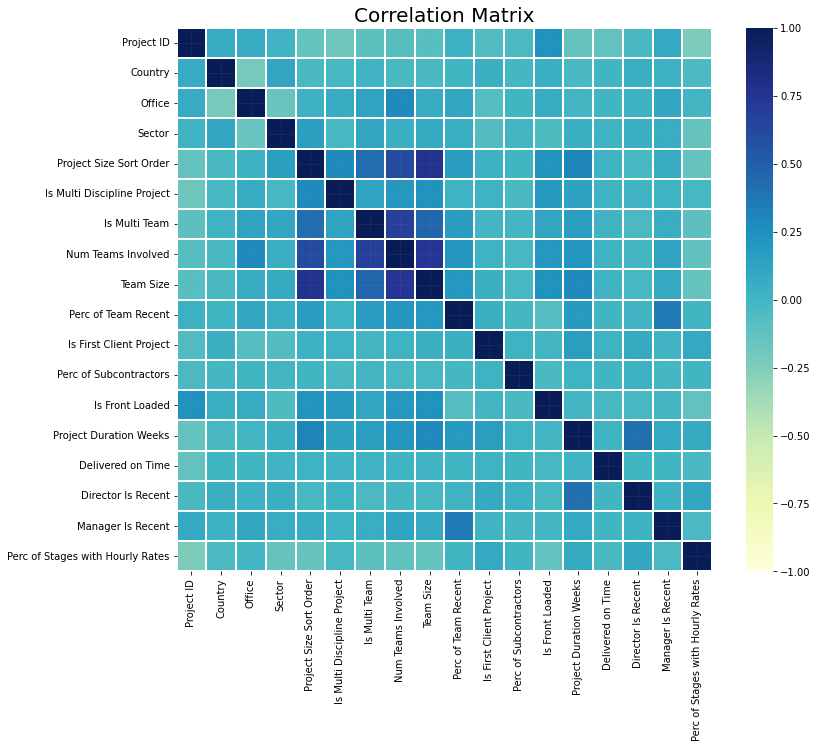

In [65]:
X = df.drop(['Profit_Margin'], axis = 1).copy()
X.columns = X.columns.str.replace('_', ' ')

corr = X.corr()
colors = sns.diverging_palette(37, 12.5, as_cmap = True)
plt.labels = []
plt.figure(figsize = (12,10))
sns.heatmap(round(corr, 3), vmin=-1, vmax=1, cmap='YlGnBu', linewidths=.2)
plt.grid(visible=False, color='#f68c1f', alpha=0.1)
plt.title('Correlation Matrix', size = 20)
plt.show()

In [69]:
vif_info = pd.DataFrame()
vif_info['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif_info['Column'] = X.columns
vif_info.sort_values('VIF', ascending=False)

,VIF,Column
14,34.403608,Delivered on Time
2,22.390877,Office
7,11.821490,Num Teams Involved
4,8.161807,Project Size Sort Order
0,7.524842,Project ID
8,6.283379,Team Size
6,4.640474,Is Multi Team
17,3.397629,Perc of Stages with Hourly Rates
3,2.761452,Sector
13,1.861771,Project Duration Weeks


In [72]:
X = df.drop(['Profit_Margin', 'Num_Teams_Involved', 'Delivered_on_Time'], axis = 1).copy()
X.columns = X.columns.str.replace('_', ' ')

vif_info = pd.DataFrame()
vif_info['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif_info['Column'] = X.columns
vif_info.sort_values('VIF', ascending=False)

,VIF,Column
2,10.263894,Office
4,7.693621,Project Size Sort Order
0,6.021606,Project ID
7,4.649543,Team Size
6,3.223701,Is Multi Team
15,2.870749,Perc of Stages with Hourly Rates
3,2.507412,Sector
12,1.857556,Project Duration Weeks
8,1.720784,Perc of Team Recent
11,1.469263,Is Front Loaded


In [ ]:
# Save the final dataframes in CSV format
projects.to_csv('csv-files/complete_projects.csv', index=False)